# NEU (Reconfigurations Map and Related Functions)

## Initializations:

In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


In [2]:
#### TEMP

N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 10**2


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(x)
%run Data_Generator.ipynb

<Figure size 640x480 with 1 Axes>

In [3]:
## TEM{}
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

## Helper Functions:

In [6]:
#----------------------------#
# Helper Functions T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out

# Approximation to max(0,x) function by smooth function
# https://math.stackexchange.com/questions/517482/approximating-a-maximum-function-by-a-differentiable-function
def abs_helper(x):
    return tf.math.sqrt(tf.math.pow(x,2)+(10**(-5)))

def max_helper(x):
    return tf.math.multiply(abs_helper(x) + x,.5)

def soft_indicator(x):
    return max_helper(tf.math.sign(x))

def bump_function(x):
    # Gaussian rescaled to [-1,1]^d
    bump_out = 1-tf.math.pow(x,2)        
    bump_out = tf.math.divide(-1,bump_out)
    bump_out = tf.math.exp(bump_out)
    # Indicator
    indicator = soft_indicator(1-x)
    # 0 outside of [-1,1]^d
    bump_out = tf.math.multiply(bump_out,indicator)
    return bump_out

## Build Reconfiguration Unit
$$
x \mapsto \exp\left(
\psi(x-c;\sigma) X
\right) (x-c) + c
$$
where:
### Workflow
1. Shifts $x \in \mathbb{R}^d$ to $x- c$; c trainable.
2. Applies the map $\psi(x;\sigma)\triangleq e^{\frac{\sigma}{\sigma-|x|}}I_{\{|x|<\sigma\}}$ component-wise.  
3. Applies transformation $x \mapsto x +b$, $b \in \mathbb{R}^d$ trainable.
4. Applies the diagonalization map to that output: $ \left(x_1,\dots,x_d\right)\mapsto
                \begin{pmatrix}
                x_1 & & 0\\
                &\ddots &\\
                0 & & x_d\\
                \end{pmatrix}.$
5. Applies map $X \mapsto XA$, $A$ is a trainable $d\times d$ matrix.
6. Applies matrix exponential.
7. Multiplies output with result of (1).
8. Re-centers output to $x +c$ where $c$ is as in (1).

In [12]:
class Reconfiguration_unit_steps(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
#         self.scale = self.add_weight(name='location',
#                                     shape=input_shape[1:],
#                                     initializer='GlorotNormal',
#                                     trainable=True)
        
        # Step 3
        self.threshold = self.add_weight(name='threshold',
                            shape=input_shape[1:],
                            initializer='GlorotUniform',
                            trainable=True)
        
        ## Steps 4-9
        self.tangentbiases = self.add_weight(name='tangentbiases',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.tangentweights = self.add_weight(name='tangentweights',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
#         self.location_b = self.add_weight(name='location_b',
#                                     shape=input_shape[1:],
#                                     initializer='GlorotUniform',
#                                     trainable=True)
 

    def call(self, input):
        ### Steps 1-2
        # Relocated
        output_steps_1_2 = input + self.location
        # Rescaled
#         output_steps_1_2 = tf.math.multiply(tf.math.abs(self.scale),output_steps_1_2)
        
        ### Step 3
        output_step_3 = tf.math.multiply(output_steps_1_2,self.threshold)
        output_step_3 = bump_function(output_step_3)    
    
        
        ### Step 4-9
        x_out = tf.math.multiply(tf.math.abs(self.tangentweights),output_step_3) + self.tangentbiases
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.diag(x_out)
        #------------------------------#
        # Using an approximation of the matrix exponential (tf.linalg.expm(x_out)) is prefeable 
        # **Since:** TF uses Sylvester's method to for (fast) computation but this requires additional assumptions on the matrix which are typically not satified...
        # **Instead:** Use a truncated power series representation (standard definition of expm) of order 4
        x_out = tf.linalg.diag(tf.ones(d+D)) + x_out + tf.linalg.matmul(x_out,x_out)/2 + tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))/6 +tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out)))/24 #+tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))))/120
        
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,input)
        
        # 9. Recenter Transformed Data
        output_steps_4_9 = x_out + self.location#_b
        
        # Return Output
        return output_steps_4_9

#### Projection Layer
Maps $\mathbb{X}\left((x,f(x))\mid \theta \right) \in \mathbb{R}^{d\times D}$ to an element of $\mathbb{R}^D$ by post-composing with the second canonical projection
$$
(x_1,x_2)\mapsto x_2
,
$$
where $x_1 \in \mathbb{R}^d$ and $x_2 \in \mathbb{R}^D$.  

In [13]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

## Define Reconfiguration

This is an iterated composition of reconfiguration units

In [14]:
# Initialize
input_layer = tf.keras.Input(shape=[d+D])
# Steps 1 and 2
reconfigure  = Reconfiguration_unit_steps()
current_layer = reconfigure(input_layer)

# Apply Reconfigurations
# for i in range(N_Reconfigurations):
#     reconfigure  = Reconfiguration_unit_steps()
#     current_layer = reconfigure(current_layer)
    
# Map back to R^D
output_layer = projection_layer(current_layer)
NEU_OLS = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# Summarize Model
#NEU_OLS.summary()

In [15]:
optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)

NEU_OLS.compile(loss = 'mse',
                optimizer = optimizer_on,
                metrics = ['mse'])

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

In [16]:
# Fit
history = NEU_OLS.fit(
          data_NEU, NEU_targets,
          epochs=Epochs)

# Predict
NEU_prediction = NEU_OLS.predict(data_NEU)

Train on 100 samples
Epoch 1/100
100/100 [==============================] - 1s 6ms/sample - loss: 0.4780 - mse: 0.4780
Epoch 2/100
100/100 [==============================] - 0s 167us/sample - loss: 0.4372 - mse: 0.4372
Epoch 3/100
100/100 [==============================] - 0s 152us/sample - loss: 0.4021 - mse: 0.4021
Epoch 4/100
100/100 [==============================] - 0s 184us/sample - loss: 0.3675 - mse: 0.3675
Epoch 5/100
100/100 [==============================] - 0s 126us/sample - loss: 0.3461 - mse: 0.3461
Epoch 6/100
100/100 [==============================] - 0s 121us/sample - loss: 0.3247 - mse: 0.3247
Epoch 7/100
100/100 [==============================] - 0s 116us/sample - loss: 0.3071 - mse: 0.3071
Epoch 8/100
100/100 [==============================] - 0s 155us/sample - loss: 0.2916 - mse: 0.2916
Epoch 9/100
100/100 [==============================] - 0s 162us/sample - loss: 0.2778 - mse: 0.2778
Epoch 10/100
100/100 [==============================] - 0s 146us/sample - loss: 0

100/100 [==============================] - 0s 102us/sample - loss: 0.1823 - mse: 0.1823
Epoch 83/100
100/100 [==============================] - 0s 126us/sample - loss: 0.1822 - mse: 0.1822
Epoch 84/100
100/100 [==============================] - 0s 158us/sample - loss: 0.1821 - mse: 0.1821
Epoch 85/100
100/100 [==============================] - 0s 106us/sample - loss: 0.1823 - mse: 0.1823
Epoch 86/100
100/100 [==============================] - 0s 119us/sample - loss: 0.1823 - mse: 0.1823
Epoch 87/100
100/100 [==============================] - 0s 127us/sample - loss: 0.1822 - mse: 0.1822
Epoch 88/100
100/100 [==============================] - 0s 113us/sample - loss: 0.1822 - mse: 0.1822
Epoch 89/100
100/100 [==============================] - 0s 124us/sample - loss: 0.1823 - mse: 0.1823
Epoch 90/100
100/100 [==============================] - 0s 133us/sample - loss: 0.1823 - mse: 0.1823
Epoch 91/100
100/100 [==============================] - 0s 147us/sample - loss: 0.1822 - mse: 0.1822
Epo

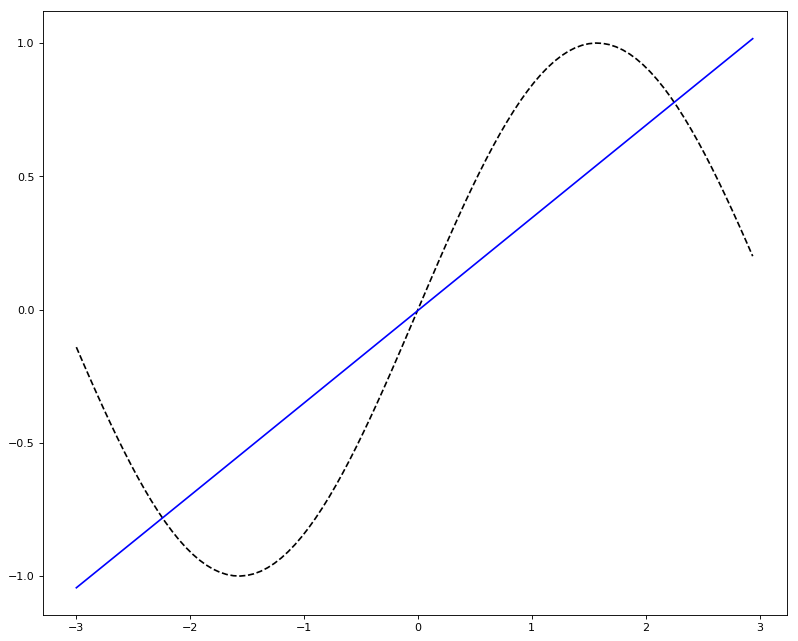

In [18]:
# import matplotlib.pyplot as plt
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Plot Models
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')
plt.plot(data_x,NEU_prediction,color='b',label='NEU-OLS')
plt.plot(data_x,model_pred_y,color='r',label='NEU-OLS')